In [1]:
!pip install deepface ultralytics faiss-cpu pandas

In [2]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

import numpy as np
import faiss

In [3]:
model_name = "Facenet" 
detector_backend = "opencv"
num_dimensions = 128 # Facenet output

In [21]:
representations = []

# Inisialisasi DataFrame Pandas untuk menyimpan nama orang dan embedding
df = pd.DataFrame(columns=["name", "embedding"])

# Dictionary untuk mapping file_name ke nama orang
file_to_name = {
    "Jenny.jpg" : "Jenny",
    "Jisoo.jpg" : "Jisoo",
    "Lisa.jpg" : "Lisa",
    "Rose.jpg" : "Rose"
}

# Dictionary posisi
name_to_position = {
    "Jenny" : "Dancer",
    "Jisoo" : "Lead Vocal",
    "Lisa" : "Rapper",
    "Rose" : "Main Vocal"
}

for r, d, files in os.walk("../Belajar-DeepFace/dataset"):
    for file in files:
        if ".jpg" in file:
            exact_file = f"{r}/{file}"
            objs = DeepFace.represent(
                img_path=exact_file,
                model_name=model_name,
                detector_backend=detector_backend
            )
            
            # Dapatkan nama orang dari dictionary
            name = file_to_name.get(file, "Unknown")  # Jika file tidak ada dalam dictionary, beri nama 'Unknown'
            posisi = name_to_position.get(name, "unknown position")
            
            for obj in objs:
                embedding = obj["embedding"]
                representations.append([file, embedding])
                
                # Buat DataFrame baru dari nama dan embedding yang dihasilkan
                new_row = pd.DataFrame({"name": [name], "embedding": [embedding], "posisi":[posisi]})
                
                # Gabungkan DataFrame baru ke DataFrame utama menggunakan pd.concat()
                df = pd.concat([df, new_row], ignore_index=True)

In [22]:
# number of dimension
for obj in objs:
    print(len(obj["embedding"]))

128


In [23]:
print(df)

    name                                          embedding      posisi
0  Jenny  [-0.7583922147750854, -2.1869425773620605, -0....      Dancer
1  Jisoo  [-0.31661882996559143, -0.5723303556442261, -0...  Lead Vocal
2   Lisa  [-0.6468027830123901, -0.6882524490356445, -0....      Rapper
3   Rose  [0.8676369190216064, -0.9633671045303345, -1.4...  Main Vocal


In [24]:
# Konversi embedding ke numpy array untuk FAISS
embeddings = df['embedding'].tolist()  # Ambil embedding dari DataFrame
embeddings = np.array(embeddings, dtype="f")  # Konversi ke numpy array

In [25]:
# Inisialisasi FAISS
index = faiss.IndexFlatL2(num_dimensions)

In [26]:
# Tambahkan embedding ke FAISS
index.add(embeddings)

In [27]:
# Simpan DataFrame ke CSV jika diperlukan
df.to_csv("face_embeddings.csv", index=False)

In [28]:
print(f"deepface unit test items have {len(representations)} images")

deepface unit test items have 4 images


In [29]:
embeddings = []
for key, value in representations:
    embeddings.append(value)

In [30]:
# euclidean
tic = time.time()
index = faiss.IndexFlatL2(num_dimensions)
toc = time.time()
print(f"faiss instance is initialized in {toc-tic} seconds")

faiss instance is initialized in 0.0010004043579101562 seconds


In [31]:
tic = time.time()
index.add(np.array(embeddings, dtype = "f"))
toc = time.time()
print(f"{len(embeddings)} vectors stored in faiss intance in {toc-tic} seconds")

4 vectors stored in faiss intance in 0.00099945068359375 seconds


In [35]:
target_path = "../Belajar-DeepFace/input/Jenny1.jpg"

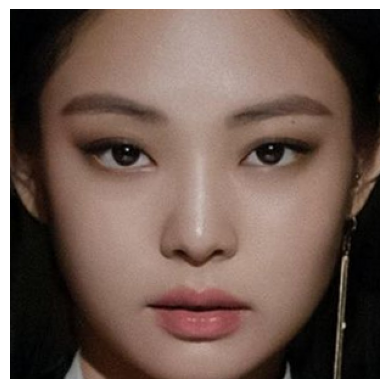

In [36]:
target_img = DeepFace.extract_faces(
    img_path = target_path, 
    detector_backend=detector_backend
)[0]["face"]
plt.imshow(target_img)
plt.axis("off")
plt.show()

In [ ]:
target_embedding = DeepFace.represent(
    img_path=target_path,
    model_name=model_name,
    detector_backend=detector_backend
)[0]["embedding"]

In [ ]:
target_embedding = np.array(target_embedding, dtype = "f")

In [ ]:
target_embedding = np.expand_dims(target_embedding, axis = 0)

In [ ]:
target_embedding.shape

In [ ]:
# Lakukan pencarian di FAISS
k = 1  # Jumlah neighbor terdekat yang ingin dicari
tic = time.time()
distances, neighbours = index.search(target_embedding, k)
toc = time.time()
print(f"search completed in {toc - tic} in seconds")

In [ ]:
print(distances)

In [ ]:
# Cek neighbor dan tampilkan informasi dari Pandas
for idx, neighbour in enumerate(neighbours[0]):
    if neighbour < len(df):
        # Ambil nama dari DataFrame berdasarkan indeks neighbor
        neighbour_name = df.iloc[neighbour]['name']
        neighbour_position = df.iloc[neighbour]['posisi']
        neighbour_img_path = f"../Belajar-DeepFace/dataset/{representations[neighbour][0]}"  # Sesuaikan path gambar ,
        # Ambil wajah neighbor dari gambar
        neighbour_img = DeepFace.extract_faces(
            img_path=neighbour_img_path,
            detector_backend=detector_backend
        )[0]["face"]
        
        # Visualisasi gambar target dan neighbor
        fig = plt.figure(figsize=(7, 7))
        fig.add_subplot(1, 2, 1)
        plt.imshow(target_img)
        plt.axis("off")
        fig.add_subplot(1, 2, 2)
        plt.imshow(neighbour_img)
        plt.axis("off")
        plt.show()
    else:
        print(f"Index {neighbour} out of range for DataFrame")

print(f"Anyyeong {neighbour_name} as {neighbour_position}, selamat datang")